# **SETTING UP**

In [1]:
#Setting up imorts

import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.metrics import Accuracy, Precision, Recall

from PIL import Image

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme()

In [2]:
#Setting up environment
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_path = '/content/drive/Shared drives/enhiselsa/Bootcamp AI/Project1' #path of the data directory

In [4]:
os.listdir(data_path) #list of directories within the data path

['gender_classification.xlsx',
 'class_identity.txt',
 'list_attribute.txt',
 'gender_classification.csv',
 'Images']

# **EXPLORATORY DATA ANALYSIS**

In [5]:
#Displaying the labelling file

url = 'https://drive.google.com/file/d/1QQ4HWQ0Zx-n6LBx19fI-OUCyzTYD5_t5/view?usp=drive_link'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
attr_list = pd.read_csv(dwn_url, delimiter= ' ', skipinitialspace= True, skiprows=1)
attr_list = attr_list.shift(-1, axis=1)
attr_list.insert(loc=0, column='img_number', value=np.arange(1,len(attr_list)+1))
attr_list = attr_list.drop(columns='Unnamed: 40')
attr_list = attr_list.replace(to_replace=-1, value=0)
# attr_list.index = attr_list['img_number'].astype(str).str.zfill(6) + '.jpg'
attr_list['img_number'] = attr_list['img_number'].apply(lambda x: str(x).zfill(6) + '.jpg')
display(attr_list.head())
print(attr_list.shape)

,img_number,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


(202599, 41)


In [6]:
# To display the botton 5 rows

display(attr_list.tail(5))

,img_number,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
202594,202595.jpg,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
202595,202596.jpg,0,0,0,0,0,1,1,0,0,...,0,1,1,0,0,0,0,0,0,1
202596,202597.jpg,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
202597,202598.jpg,0,1,1,0,0,0,1,0,1,...,0,1,0,1,1,0,1,0,0,1
202598,202599.jpg,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1


In [7]:
#To check the types of data within the dataframe

attr_list.dtypes

img_number             object
5_o_Clock_Shadow        int64
Arched_Eyebrows         int64
Attractive              int64
Bags_Under_Eyes         int64
Bald                    int64
Bangs                   int64
Big_Lips                int64
Big_Nose                int64
Black_Hair              int64
Blond_Hair              int64
Blurry                  int64
Brown_Hair              int64
Bushy_Eyebrows          int64
Chubby                  int64
Double_Chin             int64
Eyeglasses              int64
Goatee                  int64
Gray_Hair               int64
Heavy_Makeup            int64
High_Cheekbones         int64
Male                    int64
Mouth_Slightly_Open     int64
Mustache                int64
Narrow_Eyes             int64
No_Beard                int64
Oval_Face               int64
Pale_Skin               int64
Pointy_Nose             int64
Receding_Hairline       int64
Rosy_Cheeks             int64
Sideburns               int64
Smiling                 int64
Straight_H

In [8]:
#To filter the rows that contain image numbers within the images dataset folder directory

final_data = attr_list[attr_list['img_number'].isin(os.listdir(data_path + '/Images'))]
print(f'Full Data: {attr_list.shape[0]} rows')
print(f'Filtered Data: {final_data.shape[0]} rows')

Full Data: 202599 rows
Filtered Data: 5000 rows


In [9]:
#To create a new dataframe that consists of image number and its corresponding gender

final_data = final_data[['img_number', 'Male']].reset_index(drop=True)
final_data['Gender'] = final_data['Male'].map({1: 'Male', 0: 'Female'})
final_data.drop(columns='Male', inplace=True)
final_data.head()

,img_number,Gender
0,000051.jpg,Male
1,000052.jpg,Male
2,000065.jpg,Male
3,000166.jpg,Male
4,000198.jpg,Female


In [10]:
#Count female (0) and male (1)
print(f"Number of Female : {final_data['Gender'].value_counts()['Male']}")
print(f"Number of Male   : {final_data['Gender'].value_counts()['Female']}")

Number of Female : 2047
Number of Male   : 2953


From the result above, we can see that there is data imbalance. However since the percentage difference is considerably low (around 50-50), therefore the data is deemed normal.

Image shape : (218, 178, 3)


,Smiling,Male,Young,Bald
62835,1,0,1,0


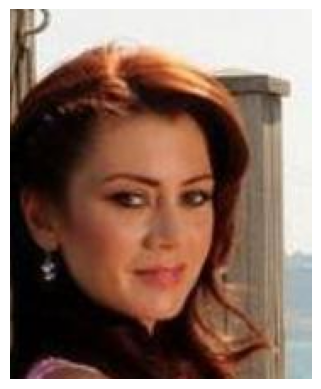

In [11]:
#Checking an exemplary data image and label

def cek_attr(a):
  img = mpimg.imread(data_path+'/Images' + "/"+ os.listdir(data_path+'/Images')[a])
  cek_1 = os.listdir(data_path+'/Images')[a]
  plt.imshow(img)
  plt.axis("off")
  print("Image shape :", img.shape)
  return attr_list.loc[attr_list['img_number'] == cek_1, ['Smiling', 'Male', 'Young', 'Bald']]
cek_attr(10)

In [12]:
# filter the data with available images only (in this case we only have 5000 images)
#possible diapus
images_list = os.listdir(data_path+'/Images')
avail_img = [img for img in images_list if img in attr_list['img_number'].tolist()]
data_final = attr_list[attr_list['img_number'].isin(avail_img)].reset_index(drop=True).iloc[:5000]

# TRAIN-TEST SPLIT

In [13]:
#Split the data into train and test sets with a 80:20 ratio

img_train, img_test = train_test_split(final_data, test_size=0.2, random_state=42)
print('Data Training: ', len(img_train))
#display(img_train['Gender'].value_counts())
print('Data Testing: ', len(img_test))

Data Training:  4000
Data Testing:  1000


In [14]:
#Split test data to validation data and testing data with a 80 : 20 ratio

img_val, img_test = train_test_split(img_test, test_size=0.2, random_state=42)

In [15]:
#Composition of dataset, so the composistion of data training, validation, and testing is 80%, 16%, 4% respectively

print('Data Training: ', len(img_train))
print('Data Validation: ', len(img_val))
print('Data Testing: ', len(img_test))

Data Training:  4000
Data Validation:  800
Data Testing:  200


# **DATA AUGMENTATION**




In [16]:
tf.random.set_seed(42)

#Generate image generator for data augmentations

datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [17]:
no_aug = ImageDataGenerator(rescale=1.0/255) #For non-training image generators

# **DATA GENERATORS**

In [18]:
# Training data generator with data augmentation
data_train = no_aug.flow_from_dataframe(img_train, data_path+'/Images',
                                        x_col='img_number',
                                        y_col='Gender',
                                        class_mode='binary',
                                        batch_size=32,
                                        seed=42,
                                        target_size=(224, 224))

# Image data generator for validation set with rescaling
data_valid = ImageDataGenerator(rescale=1.0/255)

# Image data generator for test set with rescaling
data_test = ImageDataGenerator(rescale=1.0/255)

# Training data generator for augmented images
train_gen = datagen.flow_from_dataframe(img_train, data_path+'/Images',
                                        x_col='img_number',
                                        y_col='Gender',
                                        class_mode='binary',
                                        batch_size=32,
                                        seed=42,
                                        target_size=(224, 224))

# Validation data generator for augmented images
valid_gen = datagen.flow_from_dataframe(img_val, data_path+'/Images',
                                        x_col='img_number',
                                        y_col='Gender',
                                        class_mode='binary',
                                        batch_size=32,
                                        seed=42,
                                        target_size=(224, 224))

# Test data generator for augmented images without shuffling
test_gen = datagen.flow_from_dataframe(img_test, data_path+'/Images',
                                       x_col='img_number',
                                       y_col='Gender',
                                       class_mode='binary',
                                       batch_size=32,
                                       seed=42,
                                       shuffle=False,
                                       target_size=(224, 224))


Found 4000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


# **MODEL ARCHITECTURE**

In [19]:
#Load pre-trained ResNet50 model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [20]:
#Lock initial layers to do not be trained

for layer in base_model.layers:
    layer.trainable = False

In [21]:
print("Number of Layers:", len(base_model.layers))

Number of Layers: 175


In [22]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

## **Fine Tuning 1**

In [23]:
# Create the final model
predictions = GlobalAveragePooling2D()(base_model.output)
predictions = Dense(1, activation='sigmoid')(predictions)

model = Model(inputs=base_model.input, outputs=predictions)

In [24]:
#Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

### **Training**

In [25]:
# Train model
checkpointer = ModelCheckpoint(filepath='weights.best.det.gen.hdf5',
                               verbose=1, save_best_only=True)

hist = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    callbacks=[checkpointer],
    verbose=1
)

Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 0.3655 - accuracy: 0.8447
Epoch 1: val_loss improved from inf to 0.25156, saving model to weights.best.det.gen.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 91s 652ms/step - loss: 0.3655 - accuracy: 0.8447 - val_loss: 0.2516 - val_accuracy: 0.9050
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9070
Epoch 2: val_loss improved from 0.25156 to 0.21965, saving model to weights.best.det.gen.hdf5
125/125 [==============================] - 71s 566ms/step - loss: 0.2342 - accuracy: 0.9070 - val_loss: 0.2196 - val_accuracy: 0.9112
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9160
Epoch 3: val_loss improved from 0.21965 to 0.20601, saving model to weights.best.det.gen.hdf5
125/125 [==============================] - 81s 653ms/step - loss: 0.2074 - accuracy: 0.9160 - val_loss: 0.2060 - val_accuracy: 0.9212
Epoch 4/30
125/125 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.9183
Epoch 4: val_loss did not improve from 0.20601
125/125 [==============================] - 82s 653ms/step - loss: 0.1982 - 

### **Evaluation**

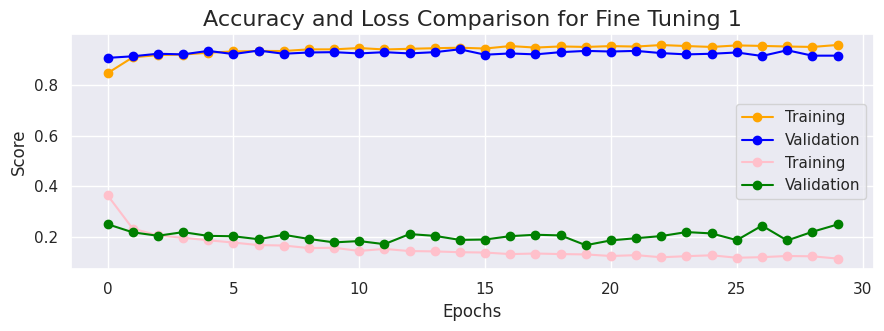

In [28]:
#Visualization result

def visualize_training(history):
    plt.figure(figsize=(9, 6))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label='Training', marker='o', color='orange')
    plt.plot(history.history['val_accuracy'], label='Validation', marker='o', color='blue')
    plt.plot(history.history['loss'], label='Training', marker='o', color='pink')
    plt.plot(history.history['val_loss'], label='Validation', marker='o', color='green')
    plt.title('Accuracy and Loss Comparison for Fine Tuning 1', fontsize=16)
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

visualize_training(hist)

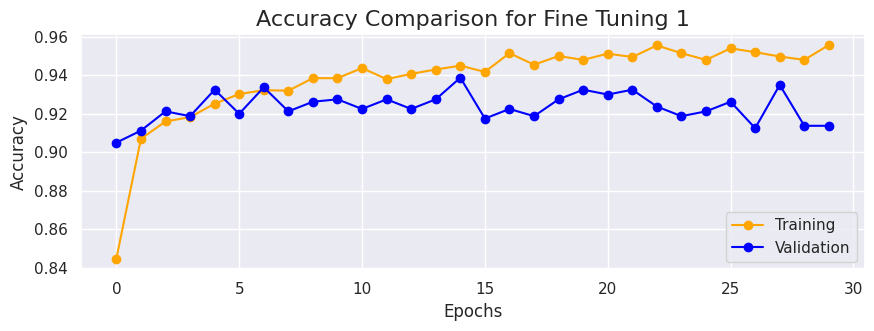

In [32]:
#Visualization result

def visualize_training(history):
    plt.figure(figsize=(9, 6))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label='Training', marker='o', color='orange')
    plt.plot(history.history['val_accuracy'], label='Validation', marker='o', color='blue')
    plt.title('Accuracy Comparison for Fine Tuning 1', fontsize=16)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

visualize_training(hist)

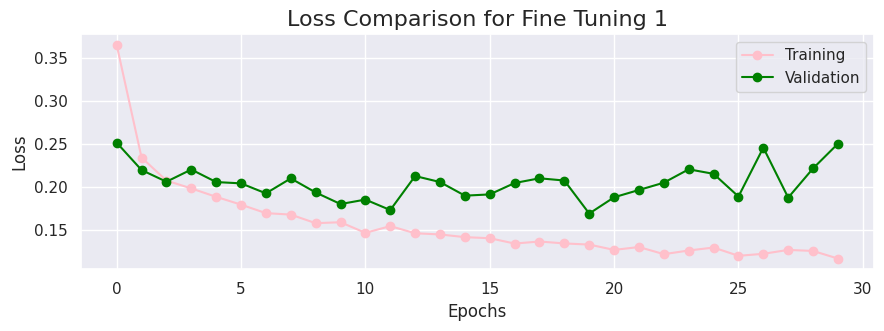

In [29]:
#Visualization result

def visualize_training(history):
    plt.figure(figsize=(9, 6))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Training', marker='o', color='pink')
    plt.plot(history.history['val_loss'], label='Validation', marker='o', color='green')
    plt.title('Loss Comparison for Fine Tuning 1', fontsize=16)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

visualize_training(hist)

Since the differences between the curves within the graphs are not of a huge difference, they show that the model does not overfit.

In [30]:
#Load the best model
model.load_weights('weights.best.det.gen.hdf5')


#Evaluate the best model using test data
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)

#Print the test accuracy
print('Test Accuracy for fine tuning 1:', test_accuracy)

7/7 [==============================] - 5s 631ms/step - loss: 0.1388 - accuracy: 0.9350
Test Accuracy for fine tuning 1: 0.9350000023841858


7/7 [==============================] - 3s 362ms/step
Classification Reports for fine tuning 1: 
              precision    recall  f1-score   support

      Female       0.93      0.98      0.96       115
        Male       0.97      0.91      0.94        85

    accuracy                           0.95       200
   macro avg       0.95      0.94      0.95       200
weighted avg       0.95      0.95      0.95       200


Confusion Matrix for fine tuning 1:


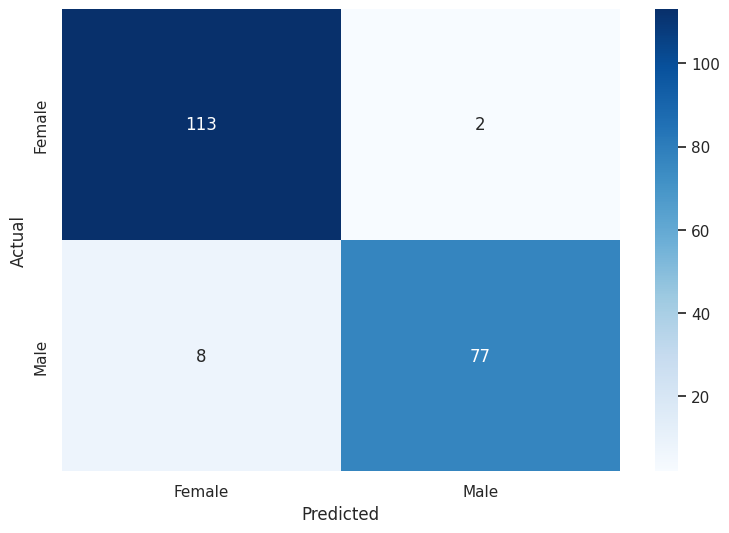

In [31]:
#Evaluate the model
y_pred = model.predict(test_gen)
y_pred = np.array(y_pred > 0.5).astype(int).flatten()
y_true = test_gen.labels

print("Classification Reports for fine tuning 1: ")
print(classification_report(y_true, y_pred, target_names=['Female', 'Male']))


print("\nConfusion Matrix for fine tuning 1:")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Female', 'Male'],
            yticklabels=['Female', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **Fine Tuning 2**

In [23]:
#Adding custom layers on top of ResNet-50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(16, activation="relu")(x)
x = Dense(8, activation="relu")(x)
x = Flatten()(x)
predictions = Dense(1, activation="sigmoid")(x)

#Merge model
model = Model(inputs=base_model.input, outputs=predictions)

In [24]:
#Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

### **Training**

In [25]:
# Train model
checkpointer = ModelCheckpoint(filepath='weights.best.det.gen.hdf5',
                               verbose=1, save_best_only=True)

hist = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    callbacks=[checkpointer],
    verbose=1
)

Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 0.3655 - accuracy: 0.8288
Epoch 1: val_loss improved from inf to 0.23977, saving model to weights.best.det.gen.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 102s 695ms/step - loss: 0.3655 - accuracy: 0.8288 - val_loss: 0.2398 - val_accuracy: 0.9087
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 0.2232 - accuracy: 0.9103
Epoch 2: val_loss improved from 0.23977 to 0.19360, saving model to weights.best.det.gen.hdf5
125/125 [==============================] - 83s 663ms/step - loss: 0.2232 - accuracy: 0.9103 - val_loss: 0.1936 - val_accuracy: 0.9250
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.9227
Epoch 3: val_loss did not improve from 0.19360
125/125 [==============================] - 81s 651ms/step - loss: 0.1975 - accuracy: 0.9227 - val_loss: 0.2544 - val_accuracy: 0.9013
Epoch 4/30
125/125 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 0.9260
Epoch 4: val_loss did not improve from 0.19360
125/125 [==============================] - 72s 576ms/step - loss: 0.1965 - accuracy: 0.9260 - val_loss: 0.2257 - val_accu

### **Evaluation**

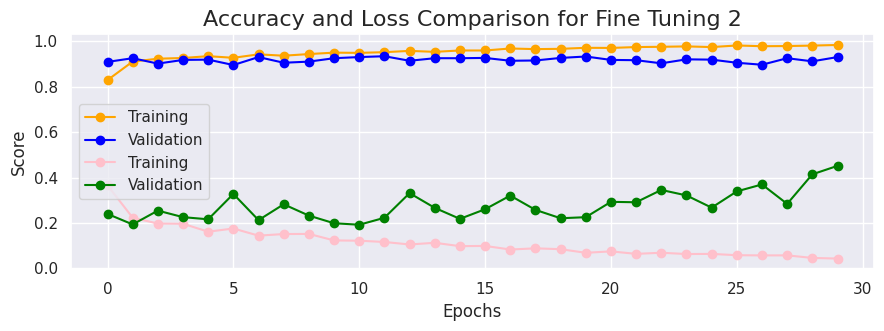

In [26]:
#Visualization result

def visualize_training(history):
    plt.figure(figsize=(9, 6))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label='Training', marker='o', color='orange')
    plt.plot(history.history['val_accuracy'], label='Validation', marker='o', color='blue')
    plt.plot(history.history['loss'], label='Training', marker='o', color='pink')
    plt.plot(history.history['val_loss'], label='Validation', marker='o', color='green')
    plt.title('Accuracy and Loss Comparison for Fine Tuning 2', fontsize=16)
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

visualize_training(hist)

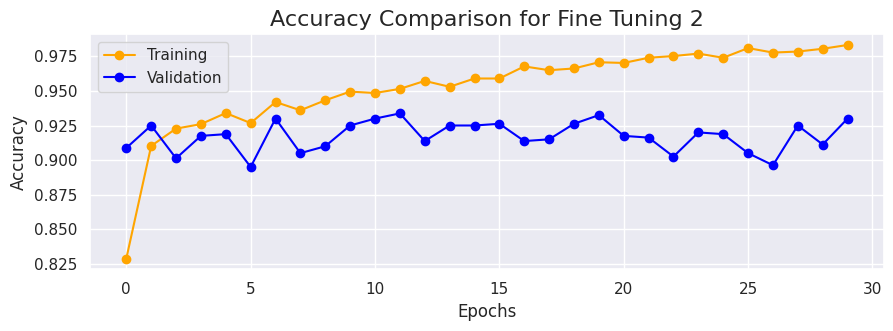

In [27]:
#Visualization result

def visualize_training(history):
    plt.figure(figsize=(9, 6))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label='Training', marker='o', color='orange')
    plt.plot(history.history['val_accuracy'], label='Validation', marker='o', color='blue')
    plt.title('Accuracy Comparison for Fine Tuning 2', fontsize=16)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

visualize_training(hist)

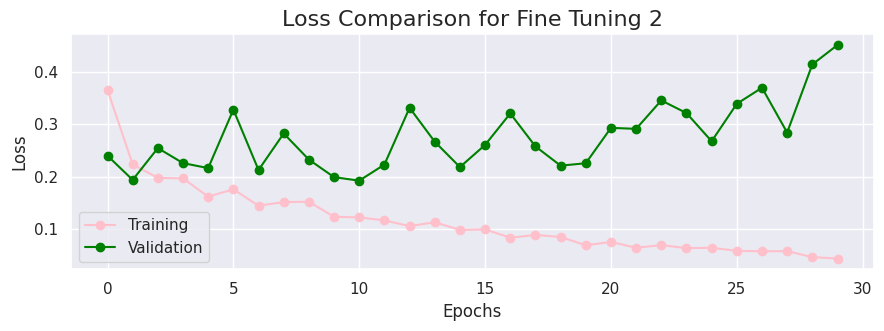

In [28]:
#Visualization result

def visualize_training(history):
    plt.figure(figsize=(9, 6))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Training', marker='o', color='pink')
    plt.plot(history.history['val_loss'], label='Validation', marker='o', color='green')
    plt.title('Loss Comparison for Fine Tuning 2', fontsize=16)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

visualize_training(hist)

Since the differences between the curves within the graphs are not of a huge difference, they show that the model does not overfit.

In [29]:
#Load the best model
model.load_weights('weights.best.det.gen.hdf5')


#Evaluate the best model using test data
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)

#Print the test accuracy
print('Test Accuracy for fine tuning 2:', test_accuracy)

7/7 [==============================] - 3s 458ms/step - loss: 0.1302 - accuracy: 0.9500
Test Accuracy for fine tuning 2: 0.949999988079071


7/7 [==============================] - 6s 581ms/step
Classification Reports for Fine tuning 2: 
              precision    recall  f1-score   support

      Female       0.97      0.96      0.96       115
        Male       0.94      0.96      0.95        85

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200


Confusion Matrix for Fine tuning 2:


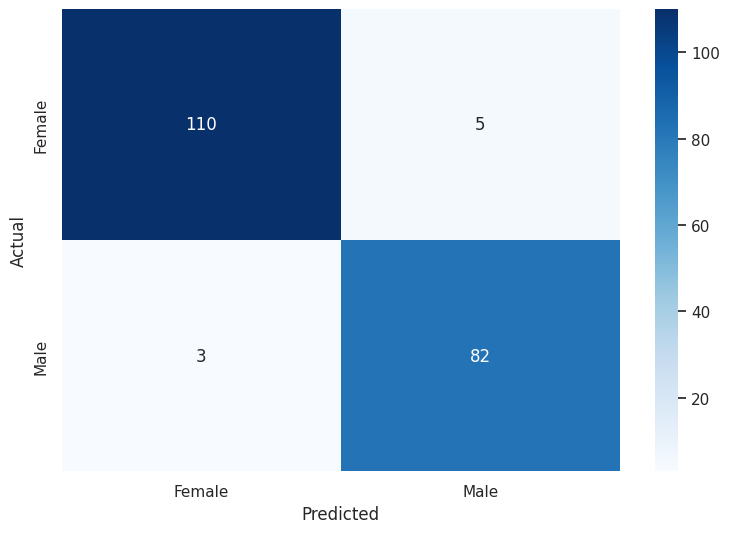

In [30]:
#Evaluate the model
y_pred = model.predict(test_gen)
y_pred = np.array(y_pred > 0.5).astype(int).flatten()
y_true = test_gen.labels

print("Classification Reports for Fine tuning 2: ")
print(classification_report(y_true, y_pred, target_names=['Female', 'Male']))


print("\nConfusion Matrix for Fine tuning 2:")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Female', 'Male'],
            yticklabels=['Female', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The difference between the two fine tunings is that, with similar configurations, the second fine tuning experiment contains more hideen layers for feature extractions, which turns out to improve the overall result by increasing the accuracy during testing.

However, since there is a data imbalance, the prioritized metric is F1, while also taking into accound the confusion matrix. And as can be seen in the results, with the second fine tuning, the results show greater F1 scores during predictions, as well as higher number of True Positives than the first form of fine tuning.